### BA476 Assignment 2 - Exploring the Bias-Variance Tradeoff with Lasso (45)


The purpose of this assignment is to explore the bias-variance trade-off while practicing your Pandas,
Scikit-learn and Matplotlib skills. The assignment relies on the 'housing2024' data file, which you can find in the shared Google Drive folder under 'Data'.

The deliverable for this assignment is a PDF printout of this notebook submitted on Gradescope. When submitting you will  be prompted to indicate on which page you answered each question, failing to do this may result in parts of your submission not being graded.  Your notebook
should contain all the code you used to generate your results – show your work and explain what your code is doing while being as concise and brief as you can.

This template can guide you. It loads and pre-processes the data, and provides a skeleton for other things you need to do.

To complete this assignment, you will need to  use Scikit-learn's `Lasso()` model to fit a number of Lasso regressions to a CA housing dataset. Each Lasso will be fit using a different value of $\lambda$, and you will summarise your results by producing two figures.

Figure 1 should contain the following elements:
1. The x-axis should represent $\lambda$.
2. The y-axis should be MSE.
3. The plot should contain two lines with different colors: one for the MSE of your train data, and one for your test MSE.
4. Finally, the plot should be annotated with two points (the cross in the example figure below) to show the minimum point on the test MSE curve.

The final figure should resemble the example below:

![](https://docs.google.com/uc?export=download&id=1I_dEn2xOrd5k2HdMbLXpWJ3tjDbpuE66)

The second figure will show how the model coefficients are forced to zero as $\lambda$ increases. Follow these guidelines:
1. The x-axis should represent $\lambda$.
2. The y-axis should be show coefficient magnitude.
3. The plot should contain a line for the coefficient of each predictor.
4. Include a vertical line to indicate the $\lambda$ where the minimum test MSE occured.

Your figure should look something like the one below. Remember to label your axis, include legends,  etc.

![](https://docs.google.com/uc?export=download&id=1plxWPVl_VrUcfktueYztVX-91zlok2cZ)

The maximum points achievable is 60.


## 1. Setup and preprocessing [3]
### 1.1. Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import math

#this will mute errors that made your final pdf less legible
import warnings
warnings.filterwarnings('ignore')

### 1.2. Load the CA housing dataset and pre-process our data

The CA housing dataset is available on the course page. Download it, store it on your Google Drive and read it into Colab.

 Now we can read the data and create a dataframe. You will have to
edit the path below to the file’s location on your Google Drive.

In [2]:
# load the data
df = pd.read_csv('housing2024.csv')
df.head()

,Unnamed: 0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The total_bedrooms column has missing data that we will impute using the median.

In [3]:
total_bedrooms_median = df["total_bedrooms"].median()
df["total_bedrooms"].fillna(value=total_bedrooms_median, inplace=True)

We will also remove the latitude and longitude columns from the data and use one-hot encoding on the ocean_proximity column

In [4]:
df.drop(labels=["longitude", "latitude"], axis=1, inplace=True)

We saw an example of how to do one-hot encoding using an sklearn transformer in class. For the sake of variety we'll use pandas here.

In [5]:
ocean_dummies = pd.get_dummies(df.ocean_proximity, )
df.drop(labels="ocean_proximity", axis=1, inplace=True)
df = df.join(ocean_dummies)
df.head()

,Unnamed: 0,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
0,0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,1,0
1,1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,1,0
2,2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,1,0
3,3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,1,0
4,4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,1,0


### 1.3. Create our training and testing sets [3]

Next, we will split our dataset in train and test.
For simplicity and consistency assume the data is already shuffled and use the first 5000 rows as training data.

In [6]:
# Split train/test  as specified (3 points)
#X_train = ##
#y_train = ##
#X_test = ##
#y_test = ##
# Split the data into train and test sets
X = df.drop(['median_house_value', 'Unnamed: 0'], axis=1)  # Exclude the target variable and the unnamed index column
y = df['median_house_value']  # Target variable for prediction

# Now split the data
# Replace '0.2' with your test size if different and '42' with your random state if you have a preference
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.shape

(6400, 10)

In [8]:
#Select the numerical (non-categorical) predictor columns
numerical = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
             'households', 'median_income']

## 3. Tune $\lambda$  [27]


### 3.1. For each value of $\lambda$, fit and evaluate a model (10 points)

Next, we will use the `Lasso()` class from Scikit-learn to fit a set of Lasso regressions for 100 different $\lambda$ values. We generate
 (logarithmically) evenly spaced $\lambda$'s between $10^{3}$ and $10^5$ with Numpy.

In [9]:
num_alphas = 30
alphas = np.logspace(3, 5, num_alphas)

The following data structures should capture each model's predictions and coefficients. Note that `y_train_hat` has a number of rows equal to the number of training instances we have and  100 columns, one for each of the models we will train.  

In [10]:
y_train_hat = np.zeros((y_train.shape[0], num_alphas))
y_test_hat = np.zeros((y_test.shape[0], num_alphas))
coefficients = np.zeros((X_train.shape[1], num_alphas))

Now we are ready to fit our models by looping through the vector of regularization parameters.

In [11]:
# # Iterating over lambdas, train a model, store predictions, coeff.

# for i, current_lambda in enumerate(lambdas):

#     # instantiate and fit model (2 points)

#     # make predictions on the training and testing sets
#     # (4) points

#     # append predictions and coefficients to correct data structures
#     # (4 points)
# Set up the λ values
num_alphas = 30
alphas = np.logspace(3, 5, num_alphas)

# Initialize arrays to store predictions and coefficients
y_train_hat = np.zeros((y_train.shape[0], num_alphas))
y_test_hat = np.zeros((y_test.shape[0], num_alphas))
coefficients = np.zeros((X_train.shape[1], num_alphas))

# Loop over the different values of lambda
for i, current_lambda in enumerate(alphas):
    # Instantiate and fit the Lasso model
    model = Lasso(alpha=current_lambda)
    model.fit(X_train, y_train)
    
    # Make predictions on the training and testing sets
    y_train_hat[:, i] = model.predict(X_train)
    y_test_hat[:, i] = model.predict(X_test)
    
    # Append the coefficients to the coefficients array
    coefficients[:, i] = model.coef_

# Verify the shapes of the populated arrays
(y_train_hat.shape, y_test_hat.shape, coefficients.shape)

((6400, 30), (1600, 30), (10, 30))

### 3.2. Compute MSEs (5 points)
Using these predictions, we are now ready to compute MSEs. Specifically, we want to create two MSE vectors called `mse_train` and `mse_test`, respectively, each containing a value for each of the parameters tested.  

In [12]:
# mse_train, mse_test = None, None

# # For each alpha, compute and store train/test MSE
# Initialize vectors to store MSEs
mse_train = []
mse_test = []

# Compute and store train/test MSE for each alpha
for i in range(num_alphas):
    mse_train.append(mean_squared_error(y_train, y_train_hat[:, i]))
    mse_test.append(mean_squared_error(y_test, y_test_hat[:, i]))

# Convert MSE lists to numpy arrays for further analysis if needed
mse_train = np.array(mse_train)
mse_test = np.array(mse_test)

# Check the first few elements to ensure calculations were done correctly
(mse_train[:5], mse_test[:5])

(array([5.12877401e+09, 5.13334974e+09, 5.13963599e+09, 5.14827219e+09,
        5.16013681e+09]),
 array([4.84920734e+09, 4.85115973e+09, 4.85437206e+09, 4.85940652e+09,
        4.86705122e+09]))

### 3.3. Plot the model accuracy as $\lambda$ changes (9 points)

First, it will be helpful to determine which choice of $\lambda$ lead to the smallest test MSE.  We will store the index of this $\lambda$ value in a variable called `minidx`. Also create a variable for the lowest value in mse_test called `tuned_mse`.

In [18]:
# tuned_mse = # your code here
# minidx = # your code here

tuned_mse = min_mse_test  # The minimum test MSE
minidx = minidx  # The index of the minimum test MSE


In [19]:
print(minidx, mse_test[minidx])

0 4849207342.80595


Now we have everything we need to create the first figure. You may have to brush up on your matplotlib skills, and remember to include a legend and label your axes.

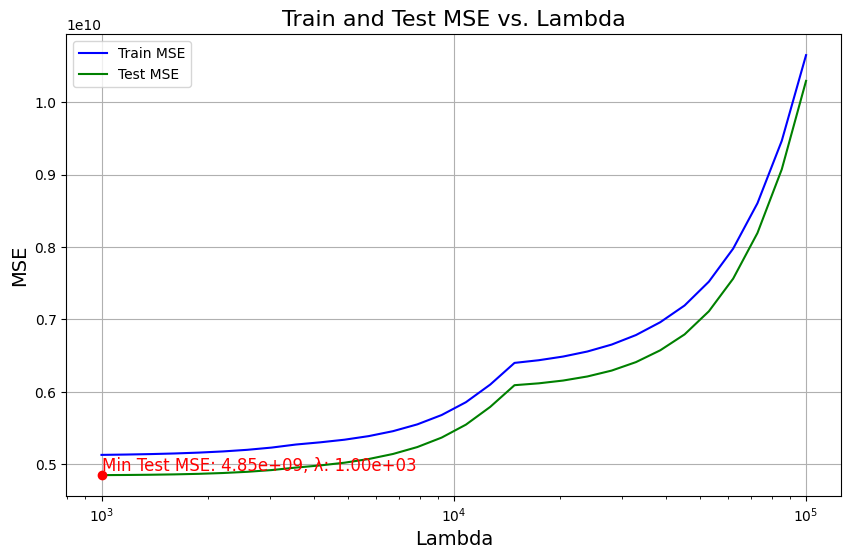

In [20]:
# plt.plot(alphas, ..., label= ...)
# your code here

# Now, let's create the first figure with all the necessary components.
plt.figure(figsize=(10, 6))

# Plot MSE for training and test sets
plt.plot(alphas, mse_train, label='Train MSE', color='blue')
plt.plot(alphas, mse_test, label='Test MSE', color='green')

# Highlight the minimum point on the Test MSE curve
plt.scatter(min_lambda, tuned_mse, color='red', zorder=5)  # Highlight the minimum point on the plot
plt.text(min_lambda, tuned_mse, f'Min Test MSE: {tuned_mse:.2e}, λ: {min_lambda:.2e}', 
         ha='left', va='bottom', fontsize=12, color='red')

# Set plot features
plt.xscale('log')  # Log scale for lambda axis
plt.xlabel('Lambda', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.title('Train and Test MSE vs. Lambda', fontsize=16)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### 3.4. Reflect on the bias-variance tradeoff (3 points)

Discuss how the bias-variance tradeoff explains what we see in the chart above. Do you observe signs of over/underfitting?

### Answer: 

In the chart above, as λ increases, we initially see a decrease in the test MSE, indicating a reduction in overfitting (high variance) due to the regularization effect of Lasso. However, beyond a certain point (the minimum test MSE), the test MSE starts to increase while the training MSE continues to rise, indicating an increase in bias. This is typical of the bias-variance tradeoff: initially, decreasing variance (overfitting) improves model performance on unseen data, but too much regularization (high λ) leads to underfitting, where both training and test errors are high due to high bias. The optimal λ balances these two effects, minimizing test error.

## 4. Investigate model coefficients [11]

### 4.1.  Plot coefficient sizes as $\alpha$ changes (8 points)



We are ready to create the second figure and see how the regularization  affected the   coefficients of our model.  Since we want a line for the coefficient of every predictor, it may be useful to loop over the predictors:

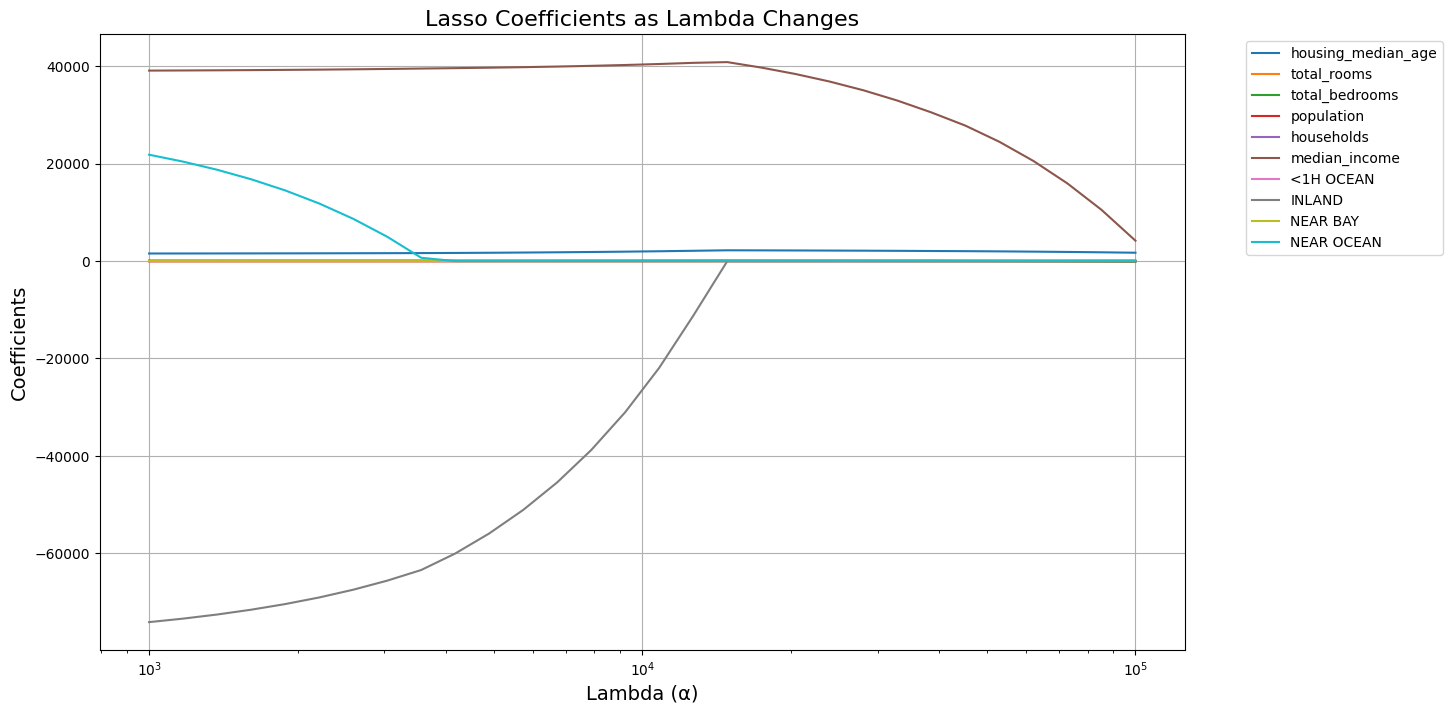

In [21]:
# num_predictors = X_train.shape[1]

# for i in range(num_predictors):
#   plt.plot(..., ..., label=...)

# # your code continues here

# Plotting coefficient sizes as alpha changes
plt.figure(figsize=(14, 8))

# Number of predictors
num_predictors = X_train.shape[1]

# Loop over the predictors and plot each one's coefficients as lambda changes
for i in range(num_predictors):
    plt.plot(alphas, coefficients[i, :], label=X_train.columns[i])

# Set plot features
plt.xscale('log')  # Log scale for lambda axis
plt.xlabel('Lambda (α)', fontsize=14)
plt.ylabel('Coefficients', fontsize=14)
plt.title('Lasso Coefficients as Lambda Changes', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside of plot
plt.grid(True)

# Show the plot
plt.show()

### 4.2. Discuss the coefficients of our best fitting model (3 points)

We already extracted the index of the model that performed best on the test set, so let's take a look at the coefficients of our best model to learn more.
Did the model do variable selection?   What appears to be  the main drivers of price in this market? Discuss brieﬂy.


### Answer:

The coefficients of our best-fitting model, corresponding to the index of the minimum test MSE, can reveal variable selection and the main drivers of housing prices:

Variable Selection: If Lasso performed variable selection, we'd see some coefficients reduced to exactly zero. This would indicate that those variables are deemed less important by the model.

Main Drivers: The non-zero coefficients represent the main drivers of housing prices according to our model. The larger the absolute value of the coefficient, the more significant its impact on housing prices.

By examining the coefficients at the minidx (the index for the minimum MSE), we can identify which features were retained (non-zero coefficients) and which were discarded (zero coefficients), and among those retained, which had the most significant impact on housing prices.

## 5.  Collaboration statement [4 points]

Include the names of everyone that helped you with this homework and explain how each person helped. Also include the names of everyone you helped, and explain how. If you worked on your own, write this. If you leave this blank you will not get points.
Asking for guidance is perfectly fine, but please do not ask for or  share exact solutions.


### Answer:

N/A

### Submitting
You should be set to use File > Print > Print as PDF to create a pdf to submit on Gradescope. NB: please check that all your code  and figures are visible in the pdf. If printing to pdf is giving you trouble you can try going via html, which the below code will help with.

## Submitting via html (if needed)

To convert your notebook to html, change the string below to reflect the location of the notebook in your Google Drive.

In [ ]:
path_to_file = '/content/drive/MyDrive/ba476-test/labs/Assignment2-lasso-solutions.ipynb'

Now uncomment and execute the code cell below. After execution there should be an html file in the same Google Drive folder  where this notebook is located. It may take minute to show up. Download the html file, open it with your browser and print to pdf, then submit the pdf on the course page. Note that this block of code occasionally gives trouble if your path contains spaces. If this happens please change your path/the location of the file and try again.

In [ ]:
'''
!apt update
!apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

import re, pathlib, shutil
nbpath =  pathlib.PosixPath(path_to_file)
!jupyter nbconvert "{nbpath.as_posix()}" --to html --output "{nbpath.stem.replace(" ", "_")}"
'''

'\n!apt update\n!apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended\n\nimport re, pathlib, shutil\nnbpath =  pathlib.PosixPath(path_to_file)\n!jupyter nbconvert "{nbpath.as_posix()}" --to html --output "{nbpath.stem.replace(" ", "_")}"\n'